# Web Track Overview

In [39]:
import pandas as pd
import numpy as np
import seaborn as sb

def cc_15_jsonl(f):
    prefix = '/mnt/ceph/storage/data-in-progress/kibi9872/sigir2021/data-13-10-2020/cc15-relevance-transfer/'
    threshold = 0.82
    df = pd.read_json(prefix + f, lines=True)
    df['urlMatches'] = df['urlMatches'] > 0
    df['urlMatchAndNearDuplicate'] = (df['urlMatches'] > 0) & (df['urlMaxS3Score'] >= threshold)
    df['nearDuplicate'] = df['maxNearDuplicateS3Score'] >= threshold
    df['nearDuplicateOrUrlDupl'] = (df['maxNearDuplicateS3Score'] >= threshold) | (df['urlMatchAndNearDuplicate'] == True)
    df['inCC15'] = (df['nearDuplicateOrUrlDupl'] == True) | (df['maxNearDuplicateS3ScoreDuplicateAware'] >= threshold)
    
    return df

df_2009 = cc_15_jsonl('web-2009.jsonl')
df_2009['corpus'] = '2009'
df_2010 = cc_15_jsonl('web-2010.jsonl')
df_2010['corpus'] = '2010'
df_2011 = cc_15_jsonl('web-2011.jsonl')
df_2011['corpus'] = '2011'
df_2012 = cc_15_jsonl('web-2012.jsonl')
df_2012['corpus'] = '2012'
df_2013 = cc_15_jsonl('web-2013.jsonl')
df_2013['corpus'] = '2013'
df_2014 = cc_15_jsonl('web-2014.jsonl')
df_2014['corpus'] = '2014'

cc_15_df = pd.concat([df_2009, df_2010, df_2011, df_2012, df_2013, df_2014])
cc_15_df = cc_15_df[cc_15_df['duplicate'] == False]

In [29]:
def cw_jsonl(f):
    prefix = '/mnt/ceph/storage/data-in-progress/kibi9872/sigir2021/data-15-10-2020/'
    df = pd.read_json(prefix + f, lines=True)
    threshold = 0.82
    
    df['inCw12'] = df['cw12Matches'] > 0
    df['inWayback'] = (df['cw12Matches'] > 0) | (df['matches'] > 0)
    df['inCW12AndNearDuplicate'] = (df['cw12Matches'] > 0) & (df['cw12UrlMaxS3Score'] >= threshold)
    df['nearDuplicate'] = df['cw12MaxNearDuplicateS3Score'] >= threshold
    df['nearDuplicateOrUrlDupl'] = (df['cw12MaxNearDuplicateS3Score'] >= threshold) | (df['inCW12AndNearDuplicate'] == True)
    df['inCw12'] = (df['nearDuplicateOrUrlDupl'] == True) | (df['cw12MaxNearDuplicateS3ScoreDuplicateAware'] >= threshold)
    df['inWaybackAndNearDuplicate'] = ((df['matches'] > 0) | (df['non200Matches'] > 0)) & ((df['waybackMachineS3Score'] >= threshold) | (df['waybackMachineS3ScoreDuplicateAware'] >= threshold))
    df['inCw12Wb12'] = (df['inWaybackAndNearDuplicate'] == True) | (df['inCw12'] == True)  
    
    return df

df_2009 = cw_jsonl('web-2009.jsonl')
df_2009['corpus'] = '2009'
df_2010 = cw_jsonl('web-2010.jsonl')
df_2010['corpus'] = '2010'
df_2011 = cw_jsonl('web-2011.jsonl')
df_2011['corpus'] = '2011'
df_2012 = cw_jsonl('web-2012.jsonl')
df_2012['corpus'] = '2012'

df_cw12 = pd.concat([df_2009, df_2010, df_2011, df_2012])
df_cw12 = df_cw12[df_cw12['duplicate'] == False]

In [3]:
cc_15_df

,topic,document,relevant,duplicate,urlMatches,urlMaxS3Score,urlMaxS3ScoreDuplicateAware,maxNearDuplicateS3Score,maxNearDuplicateS3ScoreDuplicateAware,corpus
1,44,clueweb09-en0006-84-32964,True,False,True,0.4276,0.4276,0.4276,0.4276,2009
2,44,clueweb09-en0006-84-32967,True,False,True,0.4323,0.4323,0.1646,0.1646,2009
3,44,clueweb09-en0006-84-32970,True,False,False,0.0000,0.0000,0.0000,0.0000,2009
4,44,clueweb09-en0006-84-32969,True,False,False,0.0000,0.0000,0.0000,0.0000,2009
7,44,clueweb09-en0010-84-10531,True,False,True,0.8440,0.8440,0.8440,0.8440,2009
...,...,...,...,...,...,...,...,...,...,...
14427,269,clueweb12-0100wb-76-27527,False,False,False,0.0000,0.0000,0.0000,0.0000,2014
14428,269,clueweb12-0009wb-52-27548,False,False,False,0.0000,0.0000,0.0000,0.0000,2014
14429,269,clueweb12-0212wb-14-20936,False,False,False,0.0000,0.8186,0.8193,0.8193,2014
14430,269,clueweb12-0212wb-14-20921,False,False,False,0.0000,0.7275,0.0000,0.0000,2014


In [15]:
df_treck_overview = cc_15_df.groupby(['corpus', 'topic']).aggregate(
    documents=('topic', 'count'),
    relevant=('relevant','sum')
).reset_index().groupby('corpus').aggregate(
    meanDocuments=('documents', np.mean),
    stdDocuments=('documents', np.std),
    meanRelevancy=('relevant', np.mean),
    stdRelevancy=('relevant', np.std)
).reset_index()
df_treck_overview

,corpus,meanDocuments,stdDocuments,meanRelevancy,stdRelevancy
0,2009,224.740000,35.563573,64.320000,42.480939
1,2010,438.958333,83.973136,84.520833,60.681937
2,2011,313.820000,67.825614,47.720000,47.810442
3,2012,269.140000,79.657432,52.680000,47.923596
4,2013,242.260000,85.235283,71.220000,55.664920
5,2014,235.800000,54.731627,90.060000,57.748720


In [16]:
cc_15_url_agg = cc_15_df.groupby(['corpus', 'topic']).aggregate(
    documents=('topic', 'count'),
    urlMatches=('urlMatches','sum')
).reset_index().groupby('corpus').aggregate(
    meanUrlMatches=('urlMatches', np.mean),
    stdUrlMatches=('urlMatches', np.std)
).reset_index()

In [17]:
cc_15_url_agg

,corpus,meanUrlMatches,stdUrlMatches
0,2009,30.54,12.605813
1,2010,66.75,21.106115
2,2011,47.72,20.232364
3,2012,33.66,17.476059
4,2013,33.18,23.816210
5,2014,35.90,14.448007


In [18]:
cw12_url_agg = df_cw12.groupby(['corpus', 'topic']).aggregate(
    documents=('topic', 'count'),
    urlMatches=('inCw12','sum'),
    urlMatchesIncludingWayback=('inWayback','sum')
).reset_index().groupby('corpus').aggregate(
    meanUrlMatches=('urlMatches', np.mean),
    stdUrlMatches=('urlMatches', np.std),
    meanUrlMatchesIncludingWayback=('urlMatchesIncludingWayback', np.mean),
    stdUrlMatchesIncludingWayback=('urlMatchesIncludingWayback', np.std),
).reset_index()

In [8]:
cw12_url_agg

,corpus,meanUrlMatches,stdUrlMatches,meanUrlMatchesIncludingWayback,stdUrlMatchesIncludingWayback
0,2009,56.820000,23.476162,127.14,32.159050
1,2010,109.333333,34.933574,234.00,50.161441
2,2011,75.260000,32.845221,152.12,47.883634
3,2012,68.440000,28.940587,119.38,41.496934


In [20]:
def cc15(year: str):
    i = cc_15_url_agg[cc_15_url_agg['corpus'] == year].iloc[0]
    
    return '{:.1f}'.format(i['meanUrlMatches']) + '$_{(' + '{:.1f}'.format(i['stdUrlMatches']) + ')}$'

def cw12(year: str):
    if year in ['2013', '2014']:
        return '& -- & -- '
    
    i = cw12_url_agg[cw12_url_agg['corpus'] == year].iloc[0]
    
    return '& ' + '{:.1f}'.format(i['meanUrlMatches']) + '$_{(' + '{:.1f}'.format(i['stdUrlMatches']) + ')}$ & ' +\
        '{:.1f}'.format(i['meanUrlMatchesIncludingWayback']) + '$_{(' + '{:.1f}'.format(i['stdUrlMatchesIncludingWayback']) + ')}$'

def judgments(year: str):
    i = df_treck_overview[df_treck_overview['corpus'] == year].iloc[0]
    return '{:.1f}'.format(i['meanDocuments']) + '$_{(' + '{:.1f}'.format(i['stdDocuments']) + ')}$' + ' & ' + \
        '{:.1f}'.format(i['meanRelevancy']) + '$_{(' + '{:.1f}'.format(i['stdRelevancy']) + ')}$'

def row(year: str):
    return judgments(year) + cw12(year) + ' & ' + cc15(year)


def create_table_web_track_overview():
    return """\\begin{table}
\\centering
\\small
\\setlength{\\tabcolsep}{3pt}%
\\caption{{\\color{red} Add distribution relevant vs. irrelevant.}Overview of relevance assesments of the web tracks and duplicates.}

\\label{table-web-track-overview}
%\\vspace*{-0.3cm}
\\begin{tabular}{cl@{\\hspace{0.15em}}ccccccc}
\\toprule

\\multicolumn{2}{l@{}}{\\bfseries Track} & \\multicolumn{4}{c@{}}{\\bfseries Relevance Assessments} 	& \\multicolumn{3}{c@{}}{\\bfseries Existing URLs with Judgment} 	\\\\

\\cmidrule{3-6}
\\cmidrule(l@{1em}){7-9}

& & Topics & \\#Runs & Judgments & \\#Relevant & CW12 & CW12$^{\\dagger}$ & CC15\\\\

\\midrule
\\parbox[t]{4mm}{\\multirow{4}{*}{\\rotatebox[origin=c]{90}{\\tiny CW09 \\kern-0.6em}}} 
& 2009 & 50 & 74 & """ + row('2009') + """ \\\\
& 2010 & 48 & 59 & """ + row('2010') + """ \\\\
& 2011 & 50 & 40 & """ + row('2011') + """ \\\\
& 2012 & 50 & 35 & """ + row('2012') + """ \\\\
\\midrule

\\parbox[t]{4mm}{\\multirow{2}{*}{\\rotatebox[origin=c]{90}{\\tiny CW12 \\kern-0.6em}}}
& 2013 & 50 & 37 & """ + row('2013') + """ \\\\
& 2014 & 50 & 33 & """ + row('2014') + """ \\\\
\\bottomrule
\\end{tabular}
\\end{table}
"""

table_web_track_overview = create_table_web_track_overview()
with open('/sigir21/sigir21-relevance-label-transfer-paper-submitted/table-web-track-overview.tex', 'w+') as f:
    f.write(table_web_track_overview)

In [140]:
df_all = []

for _, v in cc_15_df.iterrows():
    df_all += [{
        'corpus': 'cc15',
        'year': v['corpus'],
        'topic': v['topic'],
        'relevant': v['relevant'],
        'inCorpus': v['inCC15'],
        'method': 'url+simhash'
    }]
    
    df_all += [{
        'corpus': 'cc15',
        'year': v['corpus'],
        'topic': v['topic'],
        'relevant': v['relevant'],
        'inCorpus': v['urlMatchAndNearDuplicate'],
        'method': 'url'
    }]
    
for _, v in df_cw12.iterrows():
    df_all += [{
        'corpus': 'cw12',
        'year': v['corpus'],
        'topic': v['topic'],
        'relevant': v['relevant'],
        'inCorpus': v['inCw12'],
        'method': 'url+simhash'
    }]
    
    df_all += [{
        'corpus': 'cw12wb12',
        'year': v['corpus'],
        'topic': v['topic'],
        'relevant': v['relevant'],
        'inCorpus': v['inCw12Wb12'],
        'method': 'url+simhash'
    }]
    
    df_all += [{
        'corpus': 'cw12',
        'year': v['corpus'],
        'topic': v['topic'],
        'relevant': v['relevant'],
        'inCorpus': v['inCW12AndNearDuplicate'],
        'method': 'url'
    }]
    
    df_all += [{
        'corpus': 'cw12wb12',
        'year': v['corpus'],
        'topic': v['topic'],
        'relevant': v['relevant'],
        'inCorpus': v['inCW12AndNearDuplicate'] or v['inWaybackAndNearDuplicate'],
        'method': 'url'
    }]


df_all = pd.DataFrame(df_all)

In [114]:
df_all

,corpus,year,topic,relevant,inCorpus,method
0,cc15,2009,44,True,False,url+simhash
1,cc15,2009,44,True,False,url
2,cc15,2009,44,True,False,url+simhash
3,cc15,2009,44,True,False,url
4,cc15,2009,44,True,False,url+simhash
...,...,...,...,...,...,...
416531,cw12wb12,2012,189,False,False,url+simhash
416532,cw12,2012,189,False,False,url+simhash
416533,cw12wb12,2012,189,False,False,url+simhash
416534,cw12,2012,189,False,False,url


In [328]:
def config_axis(ax, relevant):
    ax.set(ylim=(0, 0.25))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(relevant)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(not relevant)
    ax.set_yticks([])

def plot_thing(df_all, relevant):
    font = {
        'weight': 'normal',
        'size': 16
    }

    plt.rc('font', **font)
    
    fig, ax = plt.subplots(figsize=(6, 5))
    config_axis(ax, relevant)

    plt_all = sb.barplot(x='year', y='inCorpus', data=df_all[(df_all['method'] == 'url+simhash') & (df_all['relevant'] == relevant)], palette="pastel", errwidth=0, hue='corpus', ax=ax)
    ax2 = plt_all.twinx()
    config_axis(ax2, relevant)
    plt_all = sb.barplot(x='year', y='inCorpus', data=df_all[(df_all['method'] == 'url') & (df_all['relevant'] == relevant)], errwidth=0, hue='corpus', ax=ax2)
    ax3 = plt_all.twinx()
    config_axis(ax3, relevant)

    ret = sb.barplot(x='year', y='inCorpus', alpha=0, data=df_all[(df_all['method'] == 'url+simhash') & (df_all['relevant'] == relevant)], errwidth=1, capsize=.1, palette="pastel", hue='corpus', ax=ax3)
    ax.set_title(('Relevant' if relevant else 'Irrelevant') + ' Judgments', x=0.7, y=0.9)
    ax.get_legend().remove()
    ax2.get_legend().remove()
    ax2.set_ylabel('')
    ax3.get_legend().remove()
    ax3.set_ylabel('')
    ax.set_ylabel('Transferred Judgments', fontsize=22)
    ax.set_xlabel('Web Track', fontsize=18)
    
    if relevant:
        ax.yaxis.set_label_position("right")
        ax.set_yticks([i/100 for i in range(0,26,5)])
        ax.yaxis.tick_right()
        ax.set_ylabel('')
    else:
        ax.set_yticks([i/100 for i in range(0,26,5)])
    
    fig.tight_layout()
    return fig
    

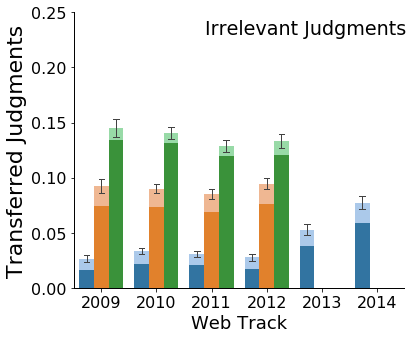

In [329]:
left_plot = plot_thing(df_all, False)
left_plot.savefig('/sigir21/sigir21-relevance-label-transfer-figures/plot-transferred-labels-left-side.pdf', format='pdf')

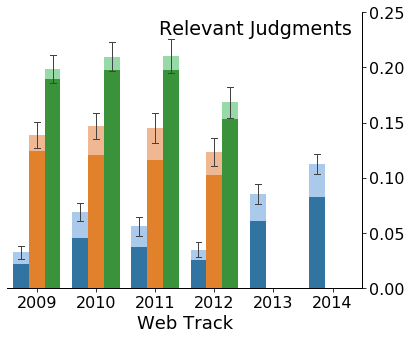

In [330]:
right_plot = plot_thing(df_all, True)
right_plot.savefig('/sigir21/sigir21-relevance-label-transfer-figures/plot-transferred-labels-right-side.pdf', format='pdf')

In [125]:
df_all[(df_all['method'] == 'url+simhash') & (df_all['corpus'] == 'cw12wb12')].inCorpus.mean()

0.14877552680823367

In [126]:
df_all[(df_all['method'] == 'url') & (df_all['corpus'] == 'cw12wb12')].inCorpus.mean()

0.1223334146936783

In [127]:
df_all[(df_all['method'] == 'url+simhash') & (df_all['corpus'] == 'cw12')].inCorpus.mean()

0.09987795948254821